In [1]:
import os
import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data = pd.read_csv('selected_data.csv')
data['GDatetime'] = pd.to_datetime(data['GDatetime'])
data.set_index('GDatetime', inplace=True)
data

,F_RunState,F_CycleTime,F_SpindleRPM1,F_SpindleTroq1,F_SpindleGearRatio1,F_ToolNum,G_ADC1,G_ADC2,G_ADC3,G_MV,G_MA,G_MActP,G_MFeq,G_MTemp,label,anomaly
GDatetime,,,,,,,,,,,,,,,,
2023-06-05 07:03:45,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,222.020004,2.974,0.924,59.970001,39.0,0,0
2023-06-05 07:03:46,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,221.529999,2.976,0.924,59.970001,39.0,0,0
2023-06-05 07:03:47,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,221.529999,2.976,0.924,59.970001,39.0,0,0
2023-06-05 07:03:48,2.0,0.0,0.0,0.0,0.0,0.0,24.400000,43.700001,0.0,220.729996,2.976,0.920,59.959999,39.0,0,0
2023-06-05 07:03:49,2.0,0.0,0.0,0.0,0.0,0.0,24.299999,43.700001,0.0,221.630005,2.962,0.920,59.959999,39.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01 16:27:16,2.0,10424.0,0.0,0.0,712.0,21.0,37.200001,38.900002,0.0,220.570007,11.092,2.656,59.970001,45.0,363,0
2023-07-01 16:27:17,2.0,10424.0,0.0,0.0,712.0,21.0,37.200001,38.900002,0.0,220.669998,11.046,2.644,59.970001,45.0,363,0
2023-07-01 16:27:18,2.0,10424.0,0.0,0.0,712.0,21.0,37.200001,38.900002,0.0,220.669998,11.046,2.644,59.970001,45.0,363,0


In [3]:
def find_cycle_periods(data, threshold_low=100, threshold_high=10000, sub_cycle_threshold=1000, sub_cycle_length_minutes=50):
    cycle_starts = []
    cycle_ends = []
    in_cycle = False
    in_high = False
    in_sub_cycle = False
    label = -1 # 주기 라벨 (0부터 시작)
    
    # label 열을 추가하고 -1로 초기화
    data['label'] = 0
    sub_cycle_start_time = None
    sub_cycle_length = 0
    
    for i in range(len(data) - 1):
        value = data['F_CycleTime'].iloc[i]
        next_value = data['F_CycleTime'].iloc[i + 1]
        
        # 주기 시작 지점 찾기 (0 ~ 100 근처에서 올라가기 시작)
        if not in_cycle and value <= threshold_low:
            in_cycle = True
            label += 1 # 새로운 주기 시작, 라벨 증가
            cycle_starts.append(data.index[i]) # datetime 인덱스 사용
        
        # 주기 내부라면 현재 라벨로 표시
        if in_cycle:
            data['label'].iloc[i] = label

        # 1만 근처의 값에 도달
        if in_cycle and not in_high and value >= threshold_high:
            in_high = True

        # 1천 근처의 값에 도달
        if in_cycle and not in_high and value >= sub_cycle_threshold:
            in_sub_cycle = True
            if sub_cycle_start_time is None:
                sub_cycle_start_time = data.index[i]

        # 하위 주기의 끝 지점 찾기
        if in_sub_cycle and next_value <= threshold_low:
            sub_cycle_length += (data.index[i] - sub_cycle_start_time).seconds / 60
            sub_cycle_start_time = None
            if sub_cycle_length >= sub_cycle_length_minutes:
                in_high = True
            in_sub_cycle = False
            
        # 주기 끝 지점 찾기
        if in_high and next_value <= threshold_low:
            in_high = False
            in_cycle = False
            cycle_ends.append(data.index[i]) # datetime 인덱스 사용
            sub_cycle_length = 0
            
    # 마지막 주기의 끝 지점 처리
    if in_cycle:
        cycle_ends.append(data.index[-1])

    return cycle_starts, cycle_ends


def remove_constant_values(data, lower_bound=1000, upper_bound=12000, duration_minutes=20):
    constant_value = None
    constant_start_time = None
    rows_to_drop = []

    for i in range(len(data) - 1):
        value = data['F_CycleTime'].iloc[i]

        # 값이 범위 내에 있고 이전 값과 동일한 경우
        if lower_bound <= value < upper_bound and value == constant_value:
            if constant_start_time is None:
                constant_start_time = data.index[i]
            # 지속 시간이 20분 이상인 경우
            if (data.index[i] - constant_start_time).seconds / 60 >= duration_minutes:
                rows_to_drop.append(data.index[i])
        else:
            constant_value = value
            constant_start_time = None

    # 행 삭제
    data.drop(rows_to_drop, inplace=True)
    return data



selected_data = data

selected_data = remove_constant_values(selected_data)

# 중복된 인덱스를 가진 행의 평균값으로 병합
selected_data = selected_data.groupby(selected_data.index).mean()

cycle_starts, cycle_ends = find_cycle_periods(selected_data)

selected_data = selected_data.iloc[:-1]
selected_data['anomaly'] = 0
specific_labels = [43, 188, 243, 256, 258, 270, 291, 295, 325, 340, 349, 360]
selected_data.loc[selected_data['label'].isin(specific_labels), 'anomaly'] = 1

In [4]:
# 최대 샘플 길이를 정의 (선택적)
max_length = max(len(selected_data.loc[start:end]) for start, end in zip(cycle_starts, cycle_ends))

def create_3d_array(data, cycle_starts, cycle_ends, max_length=None, 
                    feature_columns=['F_RunState', 'F_ToolNum', 'F_CycleTime', 'F_SpindleRPM1', 'F_SpindleTroq1', 'G_ADC1', 'G_ADC2', 'G_ADC3', 'G_MV', 'G_MActP', 'G_MTemp', 'anomaly']):
    # 주기별 샘플을 저장할 리스트
    samples = []

    # 각 주기를 샘플로 변환
    for start, end in zip(cycle_starts, cycle_ends):
        sample = data.loc[start:end][feature_columns].values
        
        # 샘플 길이 통일 (선택적)
        if max_length:
            if len(sample) > max_length:
                sample = sample[:max_length]
            elif len(sample) < max_length:
                padding = np.zeros((max_length - len(sample), len(feature_columns)))
                sample = np.vstack((sample, padding))
        
        samples.append(sample)

    # 샘플들을 3차원 배열로 쌓기
    samples_array = np.stack(samples)
    
    return samples_array

# 3차원 배열 생성
samples_array = create_3d_array(selected_data, cycle_starts, cycle_ends, max_length=max_length)

# 결과의 형태 출력
X = samples_array[:,:,:-1]
y = samples_array[:,0,-1]
X.shape, y.shape

((364, 7005, 11), (364,))

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train_val = X[:280]
y_train_val = y[:280]
X_test = X[280:]
y_test = y[280:]

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, stratify=y_train_val, random_state=42)

std = StandardScaler()
mm = MinMaxScaler()

# 초기화
X_train_sc = []
X_val_sc = []
X_test_sc = []

# 학습 데이터 변환
for sample in X_train:
    mm_sample = mm.fit_transform(sample[:, :2])
    std_sample = std.fit_transform(sample[:, 2:])
    sc_sample = np.concatenate((mm_sample, std_sample), axis=1)
    X_train_sc.append(sc_sample)

# 검증 데이터 변환
for sample in X_val:
    mm_sample = mm.transform(sample[:, :2])
    std_sample = std.transform(sample[:, 2:])
    sc_sample = np.concatenate((mm_sample, std_sample), axis=1)
    X_val_sc.append(sc_sample)

# 테스트 데이터 변환
for sample in X_test:
    mm_sample = mm.transform(sample[:, :2])
    std_sample = std.transform(sample[:, 2:])
    sc_sample = np.concatenate((mm_sample, std_sample), axis=1)
    X_test_sc.append(sc_sample)

# NumPy 배열로 변환
X_train_sc = np.array(X_train_sc)
X_val_sc = np.array(X_val_sc)
X_test_sc = np.array(X_test_sc)

In [22]:
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

seq_len = 7005
n_channels = 11

inputs = layers.Input(shape=(seq_len, n_channels))

# Body
x = layers.Conv1D(64, 10, padding='same', strides=2)(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv1D(128, 7, padding='same', strides=1)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv1D(128, 5, padding='same', strides=1)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.3)(x)

# Neck
x = layers.GlobalMaxPooling1D()(x)

# Header
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(32, kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=30)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=15, min_lr=0.001)

callbacks = [early_stopping, reduce_lr]

model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7005, 11)]        0         
                                                                 
 conv1d_12 (Conv1D)          (None, 3503, 64)          7104      
                                                                 
 batch_normalization_18 (Ba  (None, 3503, 64)          256       
 tchNormalization)                                               
                                                                 
 activation_18 (Activation)  (None, 3503, 64)          0         
                                                                 
 dropout_6 (Dropout)         (None, 3503, 64)          0         
                                                                 
 conv1d_13 (Conv1D)          (None, 3503, 128)         57472     
                                                           

In [23]:
# es_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_sc, y_train, validation_split=0.2, batch_size=64, epochs=300, callbacks=[callbacks])

Epoch 1/300
3/3 [==============================] - 7s 2s/step - loss: 2.0853 - acc: 0.5321 - val_loss: 2.0013 - val_acc: 0.0250 - lr: 0.0010
Epoch 2/300
3/3 [==============================] - 5s 2s/step - loss: 2.1177 - acc: 0.4615 - val_loss: 1.9475 - val_acc: 0.5250 - lr: 0.0010
Epoch 3/300
3/3 [==============================] - 6s 2s/step - loss: 2.0462 - acc: 0.5385 - val_loss: 1.8699 - val_acc: 0.9000 - lr: 0.0010
Epoch 4/300
3/3 [==============================] - 5s 2s/step - loss: 1.9511 - acc: 0.6218 - val_loss: 1.8852 - val_acc: 0.7500 - lr: 0.0010
Epoch 5/300
3/3 [==============================] - 6s 2s/step - loss: 1.9533 - acc: 0.5321 - val_loss: 1.9333 - val_acc: 0.3500 - lr: 0.0010
Epoch 6/300
3/3 [==============================] - 6s 2s/step - loss: 1.8784 - acc: 0.6410 - val_loss: 1.9715 - val_acc: 0.1500 - lr: 0.0010
Epoch 7/300
3/3 [==============================] - 5s 2s/step - loss: 1.8243 - acc: 0.6538 - val_loss: 2.0466 - val_acc: 0.0000e+00 - lr: 0.0010
Epoch 8/3

In [24]:
p_val = model.predict(X_val_sc)
p_test = model.predict(X_test_sc)
p_val.shape, p_test.shape

3/3 [==============================] - 0s 113ms/step


((84, 1), (84, 1))

정확도 : 0.9285714285714286
f1 : 0.0


<Figure size 640x480 with 0 Axes>

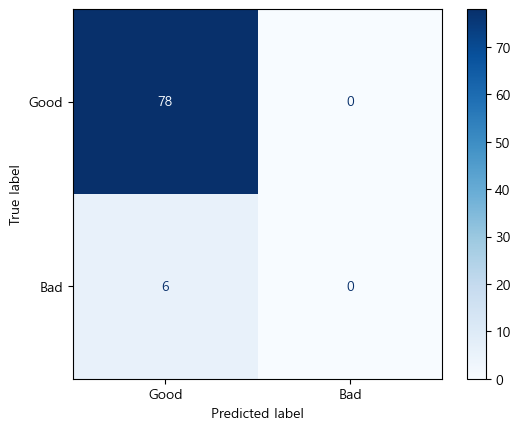

In [33]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

p_val_bin = p_val>=0.5

print('정확도 :', accuracy_score(y_test, p_val_bin))
print('f1 :', f1_score(y_test, p_val_bin))

plt.figure()
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, p_val_bin), display_labels=['Good', 'Bad']).plot(cmap='Blues')
plt.show()


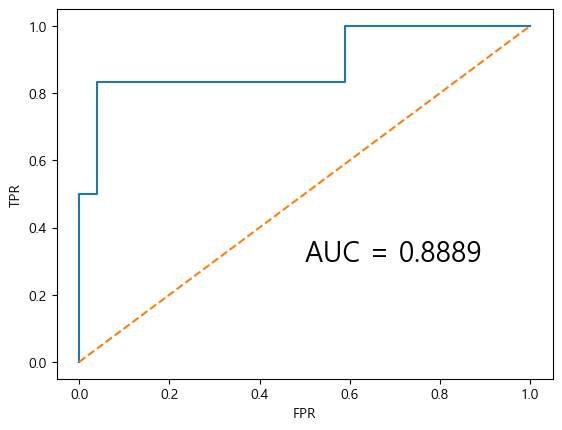

In [32]:
fpr, tpr, _ = roc_curve(y_test, p_test)
auc = roc_auc_score(y_test, p_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.text(0.5, 0.3, f'AUC = {auc:.4f}', fontsize=20)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()